In [1]:
from fastai.tabular.all import *
from fastai.collab import *

In [2]:
#loading the dataset
ratings = pd.read_csv('u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [3]:
movies = pd.read_csv('u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [4]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


In [5]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In [6]:
dls.show_batch()

,user,title,rating
0,450,"Perfect World, A (1993)",4
1,833,"Abyss, The (1989)",2
2,452,Babe (1995),4
3,572,"Celluloid Closet, The (1995)",4
4,59,Butch Cassidy and the Sundance Kid (1969),5
5,512,Pulp Fiction (1994),5
6,748,"Room with a View, A (1986)",3
7,222,Jaws 2 (1978),1
8,543,"Lost World: Jurassic Park, The (1997)",3
9,796,While You Were Sleeping (1995),5


In [7]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

SuggestedLRs(valley=0.02290867641568184)

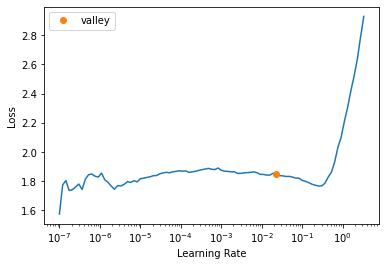

In [8]:
learn.lr_find()

In [9]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,5.449130,5.329296,00:14
1,5.505131,5.504324,00:14
2,5.586618,5.581037,00:14
3,4.107216,4.255940,00:14
4,1.020325,1.021444,00:13


In [12]:
learn.fit_one_cycle(5, 2.29e-2, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.908515,1.110201,00:14
1,1.068923,1.077808,00:14
2,0.950183,0.959124,00:15
3,0.761646,0.850943,00:15
4,0.506071,0.846767,00:14


In [11]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.501289,0.875065,00:14
1,0.561047,0.872740,00:14
2,0.486099,0.877334,00:14
3,0.364002,0.879890,00:14
4,0.256082,0.882182,00:13
